# Не относится к работе

In [ ]:
Pval = [1, 1, 2, 3, 5]

In [ ]:
def p(n):
    global Pval
    if n < 0:
        return 0
    if n < len(Pval):
        return Pval[n]
    k = 1
    rval = 0
    while True:
        p1 = p(n - (3*k**2 - k)//2)
        p2 = p(n - (3*k**2 + k)//2)
        rval += (1 if k%2 else -1)*(p1 + p2)
        if p1 < 1 or p2 < 1:
            break
        k += 1
    Pval += [0 for i in range(n - len(Pval) + 1)]
    Pval[n] = rval
    return Pval[n]

In [ ]:
# Игрушка дьявола
for i in range(1, 51):
    p(2000*i)
print(p(100000))

# Предисловие

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

plt.rcParams['figure.figsize'] = [7, 7]

## Перестановка

In [2]:
class Permutation:
    def __init__(self, per):
        if isinstance(per, tuple):
            self._per = per
            self._cycles = None
            self._cols = None
        elif isinstance(per, list):
            cycles = per
            self._per = [0]*sum([len(c) for c in cycles])
            self._cycles = cycles.deepcopy()
            
            for c in cycles:
                for idx, next_idx in zip(c, c[1:]+(c[0],)):
                    self._per[idx-1] = next_idx
        else:
            raise TypeError(f"Cannot construct a permutation from value of type {type(per)}")
        
        self._yung_diag = None
        
        self._length = len(self._per)
        self._inv = None
        
    def __str__(self):
        str_rep = ''
        max_num_len = len(self._length.__str__())
        for i, e in enumerate(self._per):
            i_str = (i+1).__str__()
            str_rep += ' '*(max_num_len-len(i_str))
            str_rep += i_str + ' -> '
            str_rep += e.__str__() + '\n'
        return str_rep + '\n'
    
    # Композиция перестановок
    def __mul__(self, other):
        if self.length() != other.length():
            raise ValueError('Composing permutations of defferent lengths')
        composition = []
        for i in range(self.length()):
            composition.append(other.element(self._per[i]))
        return Permutation(tuple(composition))
        
    def element(self, idx):
        return self._per[idx-1]
        
    def length(self):
        return self._length
    
    # Обратная перестановка
    def inv(self):
        if self._inv is None:
            inv_list = [0] * len(self._per)
            for i, e in enumerate(self._per):
                inv_list[e-1] = i + 1
            self._inv = Permutation(tuple(inv_list))
        return self._inv
    
    # Извлечение циклов
    def cycles(self):
        if self._cycles is None:
            self._cycles = []
            bool_map = 0
            next_available = 0
            while next_available < self._length:
                cur_idx = next_available
                cycle = []
                while len(cycle) < 1 or cycle[0] != (cur_idx+1):
                    cycle.append(cur_idx+1)
                    bool_map += 2**cur_idx
                    cur_idx = self._per[cur_idx]-1
                self._cycles.append(tuple(cycle))
                
                next_available += 1
                while 2**next_available & bool_map:
                    next_available += 1
        return self._cycles
    
    # Длины циклов (столбцы диаграммы Юнга) 
    def cols(self):
        if self._cols is None:
            t = [len(c) for c in self.cycles()]
            t.sort(reverse=True)
            self._cols = tuple(t)
        return self._cols
    
    def max_cycle_len(self):
        return self.cols()[0]
    
    # Визуализация диаграммой Юнга
    def yung(self):
        if self._yung_diag:
            return self._yung_diag
        
        self._yung_diag = YungDiagram()
        cols = self.cols()
        for i in range (len(cols)):
            for j in range(cols[i]):
                self._yung_diag.insertCell(Cell(i+1, j+1))
        return self._yung_diag
    
    def RSK(self):
        P = YungDiagram()
        Q = YungDiagram()

        if self.length() < 1:
            return P, Q

        c = Cell(1, 1, self.element(1))
        nCell = Cell(1, 1, 1)
        P.insertCell(c)
        Q.insertCell(nCell)
        for i in range(2, self.length()+1):
            val = self.element(i)
            col_idx = 0
            cur_val = val
            while col_idx < P.w:
                for j in range(P.lencol[col_idx]):
                    cur_cell = P.getCell(col_idx+1, j+1)
                    if cur_val < cur_cell.val:
                        cur_val, cur_cell.val = cur_cell.val, cur_val
                        col_idx += 1
                        break
                else:
                    x, y = col_idx+1, P.lencol[col_idx]+1
                    P.insertCell(Cell(x, y, cur_val))
                    Q.insertCell(Cell(x, y, i))
                    break
            else:
                x, y = col_idx+1, 1
                P.insertCell(Cell(x, y, cur_val))
                Q.insertCell(Cell(x, y, i))

        return P, Q

## Клетка диаграммы

In [3]:
class Cell:
    def __init__(self, x, y, val=0):
        self.x = x if x > 0 else 1
        self.y = y if y > 0 else 1
        if val < 1:
            self.val = None
        else:
            self.val = val
        # Длина крюка
        self.hl = None
    
    def __str__(self):
        sd = str(self.x) + ' '
        sd += str(self.y) + ' '
        sd += ('*' if not self.val else str(self.val))
        return sd

## Базовая диаграмма

In [4]:
class Diagram:
    def __init__(self, h=0, w=0, cells=None):
        self.type = 0
        self.h, self.w = (0 if h < 0 else h), (0 if w < 0 else w)
        self.cols = [[None for j in range(self.h)] for i in range(self.w)]
        self.n = 0
        if cells:
            for c in cells:
                self.insertCell(c)
    
    def __str__(self):
        s_repr = ''
        for c_col in self.cols:
            for c_row in c_col:
                if c_row:
                    s_repr += c_row.__str__()
                s_repr += '\t'
            s_repr += '\n'
        return s_repr
    
    def isCellBeyond(self, x, y):
        if 1 <= x <= self.w and 1 <= y <= self.h:
            return False
        return True
    
    def getCell(self, x, y):
        if self.isCellBeyond(x, y):
            return None
        return self.cols[x-1][y-1]
    
    def reassignValue(self, x, y, val):
        c = self.getCell(x, y)
        if not c:
            return False
        c.val = val
        return True
    
    def insertCell(self, c):
        prev_w = self.w
        if c.x > self.w:
                self.w = c.x
        if c.y > self.h:
                self.h = c.y
        self.cols += [[None for j in range(self.h)] for i in range(self.w - prev_w)]
        for i in range(prev_w):
            self.cols[i] += [None for j in range(self.h - len(self.cols[i]))]
        self.cols[c.x-1][c.y-1] = c
        self.n += 1
    
    def ejectCell(self, x, y):
        c = self.getCell(x, y)
        if not c:
            return None
        
        self.cols[x-1][y-1] = None
        
        last_col_empty = True
        last_row_empty = True
        for col_c in self.cols[self.w-1]:
            if not col_c is None:
                last_col_empty = False
                break
        for col in self.cols:
            if not col[self.h-1] is None:
                last_row_empty = False
                break
        
        if last_col_empty:
            del self.cols[self.w-1]
            self.w -= 1
        if last_row_empty:
            for col in self.cols:
                del col[self.h-1]
            self.h -= 1
        
        self.n -= 1
        return c
    
    # Является ли диаграмма таблицей
    def isTable(self, startCell=(1, 1)):
        x, y = startCell
        if self.isCellBeyond(x, y):
            return True
        
        next_is_table = self.isTable((x+1, y))
        if not next_is_table:
            return False
        
        c_col = self.cols[x-1]
        for c in c_col:
            if not c:
                y += 1
                continue
            elif not c.val:
                return False
            if x < self.w:
                right_c = self.getCell(x+1, y)
                if right_c and right_c.val <= c.val:
                    #print(f"Cell ({c.x}, {c.y}, {c.val}) right: ({right_c.x}, {right_c.y}, {right_c.val})")
                    return False
            if y < self.h:
                upper_c = self.getCell(x, y+1)
                if upper_c and upper_c.val <= c.val:
                    #print(f"Cell ({c.x}, {c.y}, {c.val}) upper: ({upper_c.x}, {upper_c.y}, {upper_c.val})")
                    return False
            y += 1
        return True
    
    def getCellsList(self):
        clist = []
        for i in range(self.w):
            for j in range(self.h):
                if self.cols[i][j]:
                    clist.append(self.cols[i][j])
        return clist
    
    def getCellsCopies(self):
        return [copy.copy(c) for c in self.getCellsList()]
    
    def draw(self, mode='val'):
        fig, ax = plt.subplots()
        clist = self.getCellsList()
        for c in clist:
            if c is None:
                continue
            r = Rectangle((c.x-0.5, c.y-0.5), 1, 1, edgecolor='black', facecolor=(0,0,0,0))
            ax.add_patch(r)
            ann = ''
            if mode == 'val':
                ann = c.val
            elif mode == 'hook_len':
                ann = c.hl
            else:
                continue
            ax.annotate(ann, (c.x, c.y), color='black', weight='normal', 
                            fontsize=14, ha='center', va='center')
        plt.axis('scaled')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.plot()
        plt.show()
        
    def save(self, fname):
        fd = open(fname, 'w')
        if not fd:
            return False
        
        fd.write(str(self.type)+'\n')
        for c in self.getCellsList():
            fd.write(c.__str__() + '\n')
        fd.close()
        return True
    
    def isEjAvail(self, x, y):
        pass
    
    def isInsAvail(self, x, y):
        pass

## Диаграмма Юнга прямой формы

In [5]:
class YungDiagram(Diagram):
    def __init__(self, cells=None):
        super().__init__()
        self.type = 1
        self.lencol = []
        if cells:
            for c in cells:
                if not self.insertCell(c):
                    break
    
    # Отношение частичного порядка
    def __le__(self, other):
        if self.w > other.w:
            return False
        for i in range(self.w):
            if self.lencol[i] > other.lencol[i]:
                return False
        return True
    
    def __gt__(self, other):
        return not self <= other
    
    def __eq__(self, other):
        return self <= other and other <= self
    
    def __ne__(self, other):
        return not self == other
    
    def __lt__(self, other):
        return other > self
    
    def __ge__(self, other):
        return not self < other
    
    # Разность диаграмм
    def __sub__(self, other):
        if self < other:
            raise ValueError('Subtraction from lesser diagram')
        
        cells = []
        for i in range(other.w):
            for j in range(other.lencol[i], self.lencol[i]):
                c = copy.copy(self.getCell(i+1, j+1))
                cells.append(c)
        
        for i in range(other.w, self.w):
            for j in range(self.lencol[i]):
                c = copy.copy(self.getCell(i+1, j+1))
                cells.append(c)
        
        return YungDiagramSlash(cells)
    
    def reading(self):
        if not self.isTable():
            return None
        clist = self.getCellsList()
        rg = []
        border = 0
        for lcol in reversed(self.lencol):
            l = border - lcol
            r = border if border < 0 else None
            rg += [c.val for c in clist[l:r]]
            border -= lcol
        return tuple(rg)
    
    def isEjAvail(self, x, y):
        c = self.getCell(x, y)
        tn = self.getCell(x, y+1)
        rn = self.getCell(x+1, y)
        # Клетка не пуста и не имеет правого/верхнего соседа - можно изъять
        return c and not (tn or rn)
    
    def isInsAvail(self, x, y):
        c = self.getCell(x, y)
        ln = self.getCell(x-1, y)
        bn = self.getCell(x, y-1)
        is_corner = (x == 1 and y == 1) or (x == 1 and bn) or (y == 1 and ln) or (ln and bn)
        # Клетка пуста и является угловой - можно вставить
        return not c and is_corner
    
    def insertCell(self, c):
        if not self.isInsAvail(c.x, c.y):
            return False
        c.hl = 1
        super().insertCell(c)
        
        # Обновление длин крюков
        for i in range(1, c.x):
            self.getCell(i, c.y).hl += 1
        for j in range(1, c.y):
            self.getCell(c.x, j).hl += 1
        
        # Учет длин столбцов
        if c.x > len(self.lencol):
            self.lencol.append(1)
        else:
            self.lencol[c.x-1] += 1
        
        return True
    
    def ejectCell(self, x, y):
        if not self.isEjAvail(x, y):
            return None
        ejected = super().ejectCell(x, y)
        
        for i in range(1, x):
            self.getCell(i, y).hl -= 1
        for j in range(1, y):
            self.getCell(x, j).hl -= 1
        
        self.lencol[x-1] -= 1
        if self.lencol[x-1] < 1:
            del self.lencol[x-1]
        
        return ejected

## Косая диаграмма Юнга

In [6]:
# Косая диаграмма Юнга
class YungDiagramSlash(Diagram):
    def __init__(self, cells=None):
        super().__init__()
        self.type = 2
        self.min_compl_diag = None
        if cells:
            for c in cells:
                if not self.insertCell(c):
                    break
    
    # Минимальная дополняющая диаграмма (если с ней склеить, получается прямая форма)
    def minComplDiag(self):
        if self.min_compl_diag:
            return self.min_compl_diag
        
        heights = []
        max_height = 0
        for i in range(self.w, 0, -1):
            raycast = False
            for j in range(1, self.h+2):
                if not raycast and self.getCell(i, j):
                    raycast = True
                    heights = [j-1] + heights
                if raycast and not self.getCell(i, j):
                    max_height = j-1
                    break
            else:
                heights = [max_height] + heights
        cells = [Cell(x+1, y+1) for x in range(len(heights)) for y in range(heights[x])]
        
        self.min_compl_diag = YungDiagram(cells=cells)
        return self.min_compl_diag
                
    def isEjAvail(self, x, y):
        c = self.getCell(x, y)
        ln = self.getCell(x-1, y)
        tn = self.getCell(x, y+1)
        rn = self.getCell(x+1, y)
        bn = self.getCell(x, y-1)
        
        is_outer = (not tn and not rn) or (not bn and not ln)
        
        return c and is_outer
    
    def isInsAvail(self, x, y):
        if len(self.cols) < 1:
            return True
        if self.getCell(x, y):
            return False
        
        ln = self.getCell(x-1, y)
        tn = self.getCell(x, y+1)
        rn = self.getCell(x+1, y)
        bn = self.getCell(x, y-1)
        
        upper_x = self.w if x > self.w else x
        upper_y = self.h if y > self.h else y
        
        if not (ln or tn or rn or bn):
            for i in range(1, upper_x+1):
                for j in range(1, upper_y+1):
                    if self.getCell(i, j):
                        print(f'Cell ({x}, {y}) has bottom, left or bottom-left restrictors!')
                        return False
            for i in range(x, self.w+1):
                for j in range(y, self.h+1):
                    if self.getCell(i, j):
                        print(self.getCell(i,j), upper_x, upper_y)
                        print(f'Cell ({x}, {y}) has top, right or top-right restrictors!')
                        return False
        
        if bn and not ln:
            for i in range(1, upper_x):
                if self.getCell(i, y) or self.getCell(i, y-1):
                    print(f'Cell ({x}, {y}) has left or bottom-left restrictors!')
                    return False
        
        if rn and not tn:
            for i in range(y+1, self.h+1):
                if self.getCell(x, i) or self.getCell(x+1, i):
                    print(f'Cell ({x}, {y}) has top or top-right restrictors!')
                    return False
        
        if tn and not rn:
            for i in range(x+1, self.w+1):
                if self.getCell(i, y) or self.getCell(i, y+1):
                    print(f'Cell ({x}, {y}) has right or top-right restrictors!')
                    return False
        
        if ln and not bn:
            for i in range(1, upper_y):
                if self.getCell(x, i) or self.getCell(x-1, i):
                    print(f'Cell ({x}, {y}) has bottom or bottom-left restrictors!')
                    return False
        
        return True
    
    def insertCell(self, c):
        if not self.isInsAvail(c.x, c.y):
            return False
        super().insertCell(c)
        return True
    
    def ejectCell(self, x, y):
        if not self.isEjAvail(x, y):
            return None
        return super().ejectCell(x, y)
    
    def pullDesc(self, x, y):
        if x < 1 or y < 1 or x > self.w or y > self.h or self.getCell(x, y):
            return
        
        while x <= self.w and y <= self.h:
            right_cell = self.getCell(x+1, y)
            upper_cell = self.getCell(x, y+1)
            
            if upper_cell or right_cell:
                pass
            else:
                break
            
            newX, newY = x, y+1
            target = upper_cell
            if right_cell and (not target or right_cell.val < target.val):
                newX, newY = x+1, y
                target = right_cell
            ejected = super().ejectCell(target.x, target.y)
            ejected.x -= newX - x
            ejected.y -= newY - y
            super().insertCell(ejected)
            
            x, y = newX, newY
    
    def JDT(self):
        if not self.isTable():
            print("Unable to apply JDT - the diagram is not a table!")
            return None

        T = YungDiagramSlash(cells=self.getCellsCopies())
        C = T.minComplDiag()
        corners = []

        for i in range(len(C.lencol)):
                x, y = i+1, C.lencol[i]
                if C.getCell(x, y).hl == 1:
                    corners.append((x, y))

        while len(corners) > 0:
                x_corn, y_corn = corners[0]
                del corners[0]
                C.ejectCell(x_corn, y_corn)

                if x_corn > 1 and C.getCell(x_corn-1, y_corn).hl == 1:
                    corners.append((x_corn-1, y_corn))
                if y_corn > 1 and C.getCell(x_corn, y_corn-1).hl == 1:
                    corners.append((x_corn, y_corn-1))

                T.pullDesc(x_corn, y_corn)

        return YungDiagram(cells=T.getCellsList())

## Генератор случайных перестановок и загрузка диаграмм

In [7]:
# Генератор случайных перестановок
def FisherYates(n=1):
    a = [i+1 for i in range(n)]
    for i in range(n-1):
        j = np.random.randint(i, n)
        a[j], a[i] = a[i], a[j]
    return tuple(a)

constructors = {
    0: Diagram,
    1: YungDiagram,
    2: YungDiagramSlash
}
    
def load(fname):
    diag = None
    fd = open(fname, 'r')
    if fd:
        ls = fd.readlines()
        t = int(ls[0])
        
        clist = []
        for l in ls[1:]:
            spl = l.split(' ')
            x, y, val = int(spl[0]), int(spl[1]), int(spl[2])
            clist.append(Cell(x, y, val))
        
        if not t in constructors.keys():
            print(f'Unable to determine diagram type {t}, defaulting to base Diagram')
            t = 0
        diag = constructors[t](cells=clist)
        fd.close()
    return diag

# Лабораторная №1: Постоянная Голомба-Дикмана

Исходная перестановка:
 1 -> 17
 2 -> 10
 3 -> 9
 4 -> 18
 5 -> 12
 6 -> 15
 7 -> 13
 8 -> 5
 9 -> 1
10 -> 7
11 -> 11
12 -> 6
13 -> 2
14 -> 14
15 -> 8
16 -> 16
17 -> 3
18 -> 4


Обратная перестановка:
 1 -> 9
 2 -> 13
 3 -> 17
 4 -> 18
 5 -> 8
 6 -> 12
 7 -> 10
 8 -> 15
 9 -> 3
10 -> 2
11 -> 11
12 -> 5
13 -> 7
14 -> 14
15 -> 6
16 -> 16
17 -> 1
18 -> 4


Циклы:
[(1, 17, 3, 9), (2, 10, 7, 13), (4, 18), (5, 12, 6, 15, 8), (11,), (14,), (16,)]
Высоты столбцов, aka длины циклов (по убыванию):
(5, 4, 4, 2, 1, 1, 1)
Максимальная длина цикла: 5

Диаграмма Юнга:


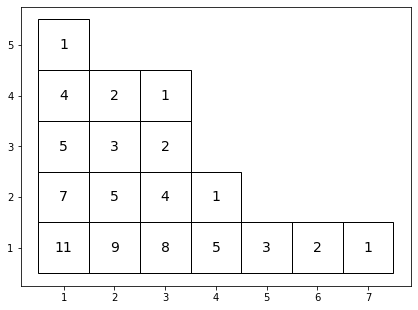

In [8]:
sample_per = (17, 10, 9, 18, 12, 15, 13, 5, 1, 7, 11, 6, 2, 14, 8, 16, 3, 4)
sp = Permutation(sample_per)

print("Исходная перестановка:", sp, sep='\n')
print("Обратная перестановка:", sp.inv(), sep='\n')
print("Циклы:", sp.cycles(), sep='\n')
print("Высоты столбцов, aka длины циклов (по убыванию):", sp.cols(), sep='\n')
print("Максимальная длина цикла:", sp.max_cycle_len())
print()
print("Диаграмма Юнга:")
sp.yung().draw(mode='hook_len')

In [9]:
lengths = (10, 50, 100, 1000)
amounts = (50, 100, 1000, 10000)

for n in lengths:
    for N in amounts:
        obs = []
        for i in range(N):
            rp = Permutation(FisherYates(n))
            obs.append(rp.max_cycle_len()/rp.length())

        print()
        print(f'n = {n}, N = {N}')
        print('Mean: {:.6f}'.format(np.mean(obs)))
        print('Variance: {:.6f}'.format(np.std(obs)**2))


n = 10, N = 50
Mean: 0.702000
Variance: 0.035396

n = 10, N = 100
Mean: 0.634000
Variance: 0.039244

n = 10, N = 1000
Mean: 0.649000
Variance: 0.042539

n = 10, N = 10000
Mean: 0.653620
Variance: 0.040279

n = 50, N = 50
Mean: 0.621600
Variance: 0.035069

n = 50, N = 100
Mean: 0.628200
Variance: 0.041697

n = 50, N = 1000
Mean: 0.634220
Variance: 0.037631

n = 50, N = 10000
Mean: 0.634102
Variance: 0.037617

n = 100, N = 50
Mean: 0.627000
Variance: 0.035389

n = 100, N = 100
Mean: 0.628900
Variance: 0.035368

n = 100, N = 1000
Mean: 0.626750
Variance: 0.035622

n = 100, N = 10000
Mean: 0.625004
Variance: 0.036955

n = 1000, N = 50
Mean: 0.645760
Variance: 0.040813

n = 1000, N = 100
Mean: 0.620690
Variance: 0.039096

n = 1000, N = 1000
Mean: 0.629402
Variance: 0.035240

n = 1000, N = 10000
Mean: 0.623635
Variance: 0.036616


# Лабораторная №2: Игра "15"

## Генерация таблиц

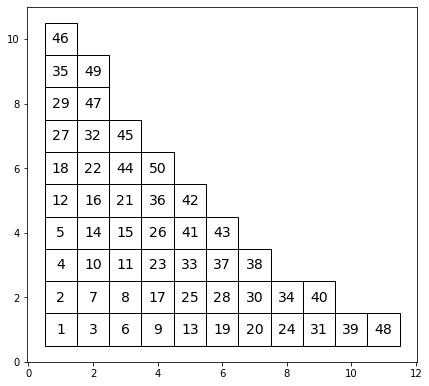

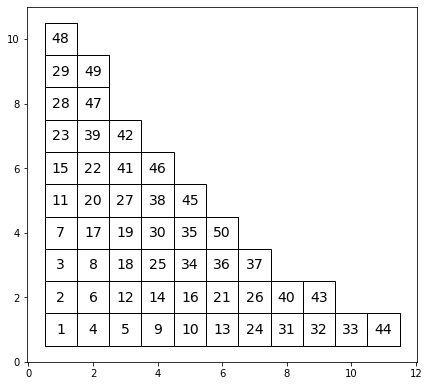

In [10]:
#sample_per = (17, 10, 9, 18, 12, 15, 13, 5, 1, 7, 11, 6, 2, 14, 8, 16, 3, 4)
sample_per = FisherYates(50)
sp = Permutation(sample_per)
P, Q = sp.RSK()
P.draw()
Q.draw()

In [ ]:
P.save("P_sample.txt")
Q.save("Q_sample.txt")

In [11]:
P, Q = load("P_sample.txt"), load("Q_sample.txt")

## Разборка Q, затем вычитаем Q из P и добавляем еще клеток

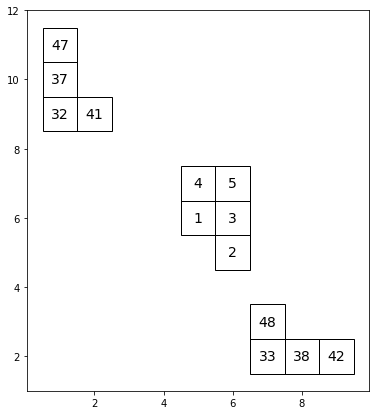

True

In [12]:
# Верхний левый кусок
Q.ejectCell(1,11)
Q.ejectCell(1,10)
Q.ejectCell(2,9)
Q.ejectCell(1,9)

# Кусок из правой части
Q.ejectCell(7,3)
Q.ejectCell(9,2)
Q.ejectCell(8,2)
Q.ejectCell(7,2)

PQslash = P - Q

# Кусок посередине
PQslash.insertCell(Cell(6,5,2))
PQslash.insertCell(Cell(6,6,3))
PQslash.insertCell(Cell(5,6,1))
PQslash.insertCell(Cell(5,7,4))
PQslash.insertCell(Cell(6,7,5))

PQslash.draw()
PQslash.save("slash_example.txt")

## Загрузка и проверка табличности

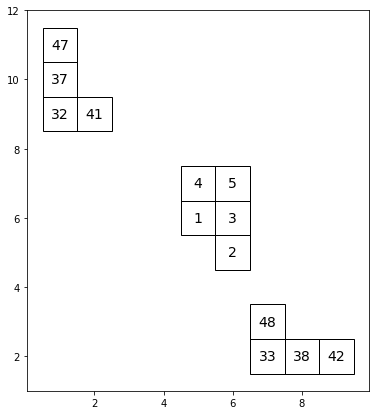

Диаграмма является косой таблицей Юнга


In [13]:
slash = load("slash_example.txt")
#slash.reassignValue(6,6,7)
slash.draw()
print(f"Диаграмма {('' if slash.isTable() else 'не ')}является косой таблицей Юнга")

## Минимальная дополняющая диаграмма прямой формы

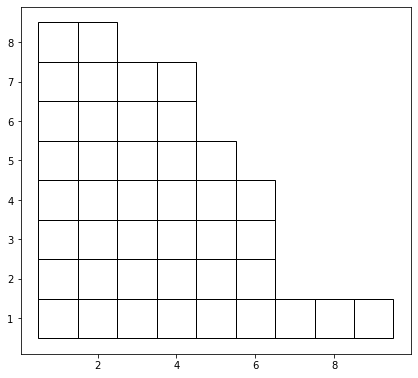

In [14]:
slash.minComplDiag().draw()

## Непосредственно JDT

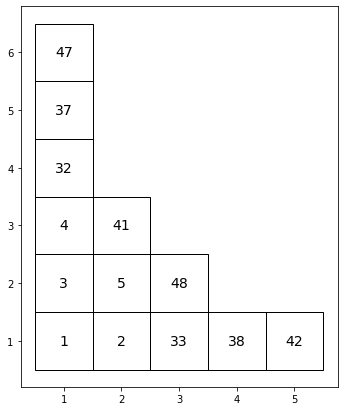

Диаграмма является таблицей Юнга прямой формы


In [15]:
jdt = slash.JDT()
#jdt.reassignValue(3,1,6)
jdt.draw()
print(f"Диаграмма {('' if jdt.isTable() else 'не ')}является таблицей Юнга прямой формы")

## Проверка по RSK

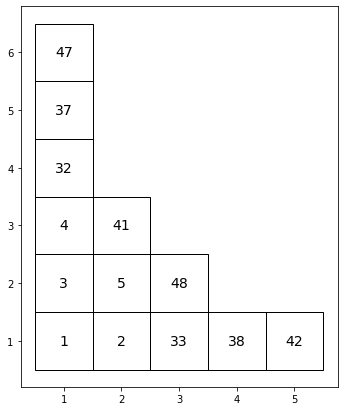

In [16]:
rg = jdt.reading()
rp = Permutation(rg)
Pr, Qr = rp.RSK()
Pr.draw()